# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

## Validación cruzada

El objetivo de este apartado entrenar la red neuronal con todos los datos de la base de datos 2dFootwear que contiene la etiqueta de la marca, para posteriormente hacer algúnas predicciones con la otra base de datos (FD300).

   En este caso, los datos que se utilizan para realizar predicciones no dispone de información sobre la marca, por ello se realizará una comprobación qualitativa visual del resultado preseleccionado imágenes que se intuya la marca.




In [25]:
#librerias necesarias:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import skimage
import cv2 


## Lectura

In [9]:
def unzipImages(folder='images'):
    with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
      zipObj.extractall(folder)
    with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
      zipObj.extractall(folder)

In [10]:
if not os.path.isdir("images"):
    unzipImages("images")

In [11]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco

X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()
values_brand, counts_brand = np.unique(brands, return_counts=True)
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo



In [12]:

def filterMinSamples(data, minSamples, deleteNone=True):
    if deleteNone == True:
        data=data[data['x']!="None"] #eliminar marca = "None"
    dataone=data[data['y']<minSamples] #marcas con pocas muestras
    data=data[data['y']>=minSamples] #marcas con minimo "minSamples" muestras
    num_classes=len(data)
    print('Brands with at least '+str(minSamples)+' samples: %d' %num_classes) 
    print('Brands with only 1 register: %d' %len(dataone)) 
    return data, dataone

dfbrandall = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 

dfbrand, dfbrandone = filterMinSamples(dfbrandall, 5)

num_classes=len(dfbrand)
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente




Brands with at least 5 samples: 7
Brands with only 1 register: 52


In [13]:
def crop_jpeg(crop_size, imgPath):
    dir_list = os.listdir("./"+imgPath)
    for f in dir_list:
        im = Image.open("./"+imgPath+"/"+f)
        h,w,c = im.shape
        im3 = im2.crop((crop_size,crop_size,h-(crop_size*2),w-(crop_size*2))) #Quitar marco medidor

def get_images_full_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result


def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list:  
    result.append(f)


  print('Nº files:',len(result))
  return result

In [14]:
#shoeFiles = get_images_to_jpeg("images")
shoeFiles = get_images("images")

Nº files: 1500


### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar

In [15]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

In [16]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    files.append(image) #filename
    person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
    brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 

def filterBrands(data, one, deleteNone=True):
    #dfbrandone creado antes con las marcas que no cumplen.
    df_shoe_brand=data[~data['y'].isin(one['x'].to_numpy())]
    
    if deleteNone == True:
        df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
    
    
    df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
    
    return df_shoe_brand

df_shoe_brand_all = filesWithBrand(shoeFiles) #contiene todas las muestras

#eliminar aquellas marcas que no aparecen mínimo en "minSample" muestras 
df_shoe_brand = filterBrands(df_shoe_brand_all,dfbrandone)
#número de marcas con 5 o más muestras:
print('Nº of brands: %d' %num_classes)
show_brands = df_shoe_brand.drop_duplicates(subset = "y")
show_brands = show_brands[['y','factor_brand']]
show_brands

Nº of brands: 7


,y,factor_brand
3,Asics,0.0
8,Skechers,1.0
15,Sperry,2.0
17,Adidas,3.0
18,Nike,4.0
31,Converse,5.0
57,Saucony,6.0


In [17]:
shoes_train = df_shoe_brand #todas las imágenes como TRAIN

In [18]:
!pip install opencv-contrib-python==4.4.0.44 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Entrenar el modelo con 100% de los datos en TRAIN


Se han entrenado 4 modelos utilizando el 100% de los datos de la primera base de datos (2dfootwear), en estos modelos se utilizan diferentes valores en los paramatros:
- epoch = 10 o 30  
- aumentación  

Posteriormente se realizan experimentos con las mismas imágenes y se comparan resultados.

Durante el proceso de entreno, se guardan los modelos obtenidos en ficheros, para agilizar siguientes ejecuciones y experimentos.

In [19]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
from skimage.color import rgb2gray
import numpy as np
import random
import os
from skimage import io
from skimage import transform, util
import cv2  as cv



#función que elimina las filas y columnas en blanco:
def crop_image(gray, pixel_value=220):
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    crop_rows = gray[~np.all(gray > pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows > pixel_value, axis=0)]
    return cropped_image

def create_variation(theImage,doFlip,doNoise,doRotate, doCrop = False):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    # Constructor. Input parameters are:
    # * fileNames   : List of sample file names
    # * doRandomize : If True, the provided file names are shuffled after each training epoch
    #                 and each image can be left unchanged, flipped, corrupted with
    #                 noise or rotated. 8 possible combinations is chosen randomly with equal probability.
    #                 If False, file names are not shuffled and each image is provided unchanged.
    # * imgPath     : Path to the images 
    # * batchSize   : Number of sample images and ground truth items in each batch
    def __init__(self,data, df_shoe_brand,doRandomize=False,imgPath='images', doGray=True,doBin=True, doCrop = True,batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.df_shoe_brand=df_shoe_brand
        self.doGray=doGray
        self.doBin=doBin
        self.doCrop=doCrop
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    
    # Input  : theIndex - Index of the image to load within self.fileNames.
    # Output : theImage - Loaded (and possibly transformed) image. Must be
    #                     of float type with values within [0,1]
    #          theClass - Shoe brand
    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
        
        
        img = io.imread(self.imgPath+file)
        h,w,c = img.shape #guardar el shape por si se hace crop poder hacer el resize 
        if self.doGray:#escala de grises
            img = rgb2gray(img)
            #plot_image_grey(img)
        if self.doBin: #blanco y negro
            test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
        if self.doCrop: #quitar columnas/filas blancas
            img = crop_image(img)
            img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
        
        theImage = img_as_float(img) 
        
        theImage=theImage /255.0 #normalizar (quito rescaling del modelo)

        #añadir aumentación a las imágenes:
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 

        #Buscar la imagen en el csv para extraer la Marca:
        person = self.df_shoe_brand[self.df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]
        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [20]:

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf
def createModelTest(color):
    if color == True:
        shape = (280,832,3)
    else:
        shape = (280,832,1)
    model_test = models.Sequential([
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax'),
      Flatten()
    ])
    return model_test

In [21]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [22]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        print(predicted)
        sort_index = np.argsort(-predicted)
        print(sort_index)
    else:
        print(predicted)

In [26]:
def fitModelCross(aumentation, gray, binary, crop, epoch):
   
    modelTest = createModelTest(not gray)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    #testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    #valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator, epochs=epoch)
    
    
    return trainHistory, modelTest
    
    

### Entrenamiento de las 4 variantes de modelo

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
77/77 [==============================] - 89s 1s/step - loss: 2.1017 - accuracy: 0.3390
Epoch 2/10
77/77 [==============================] - 97s 1s/step - loss: 0.9683 - accuracy: 0.6532
Epoch 3/10
77/77 [==============================] - 82s 1s/step - loss: 0.5208 - accuracy: 0.8377
Epoch 4/10
77/77 [==============================] - 74s 959ms/step - loss: 0.2623 - accuracy: 0.9325
Epoch 5/10
77/77 [==============================] - 72s 933ms/step - loss: 0.1494 - accuracy: 0.9506
Epoch 6/10
77/77 [==============================] - 72s 939ms/step - loss: 0.1083 - accuracy: 0.9701
Epoch 7/10
77/77 [==============================] - 72s 939ms/step - loss: 0.0527 - accuracy: 0.9857
Epoch 8/10
77/77 [==============================] - 74s 954ms/step - loss: 0.0879 - accuracy: 0.9740
Epoch 9/10
77/77 [==============================] - 72s 939ms/step - loss: 0.0893 - accuracy: 0.9779
Epoch 10/

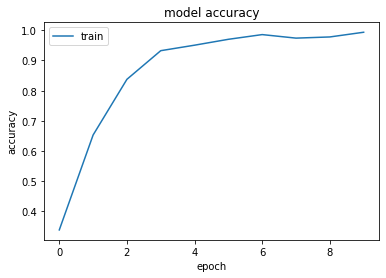

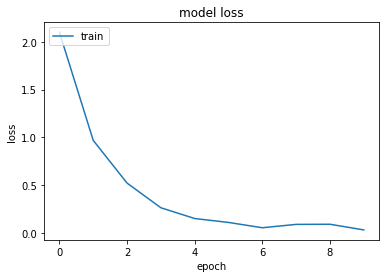

In [81]:

history, model_10_no_aum = fitModelCross(False, True, True, True, 10)
plot_history_2(history)
model_10_no_aum.save('models/cross_val_10_no_aum.h5')

In [ ]:
#ejecutar si ya esta guardado
model_10_no_aum = load_model('models/cross_val_10_no_aum.h5', compile=False) 

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
77/77 [==============================] - 78s 1000ms/step - loss: 7.7104 - accuracy: 0.2403
Epoch 2/10
77/77 [==============================] - 76s 982ms/step - loss: 7.2462 - accuracy: 0.2117
Epoch 3/10
77/77 [==============================] - 75s 967ms/step - loss: 6.9125 - accuracy: 0.2766
Epoch 4/10
77/77 [==============================] - 74s 964ms/step - loss: 6.7126 - accuracy: 0.2909
Epoch 5/10
77/77 [==============================] - 74s 962ms/step - loss: 6.7549 - accuracy: 0.3130
Epoch 6/10
77/77 [==============================] - 75s 965ms/step - loss: 6.5401 - accuracy: 0.3610
Epoch 7/10
77/77 [==============================] - 75s 967ms/step - loss: 6.4349 - accuracy: 0.3286
Epoch 8/10
77/77 [==============================] - 75s 966ms/step - loss: 7.6417 - accuracy: 0.3052
Epoch 9/10
77/77 [==============================] - 75s 964ms/step - loss: 7.4692 - accuracy: 0.3221


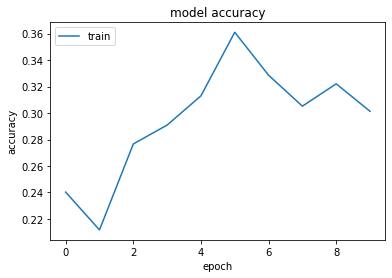

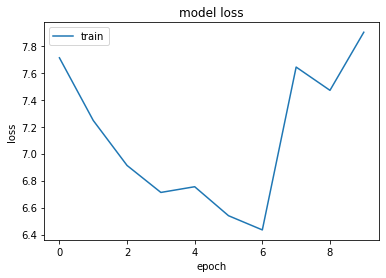

In [82]:

history, model_10_aum = fitModelCross(True, True, True, True, 10)
plot_history_2(history)
model_10_aum.save('models/cross_val_10_aum.h5')
  
    

In [ ]:
model_10_aum = load_model('models/cross_val_10_aum.h5', compile=False)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 30
Epoch 1/30
77/77 [==============================] - 75s 960ms/step - loss: 4.2069 - accuracy: 0.2545
Epoch 2/30
77/77 [==============================] - 72s 936ms/step - loss: 1.3390 - accuracy: 0.4961
Epoch 3/30
77/77 [==============================] - 72s 930ms/step - loss: 0.8391 - accuracy: 0.7221
Epoch 4/30
77/77 [==============================] - 72s 927ms/step - loss: 0.5040 - accuracy: 0.8494
Epoch 5/30
77/77 [==============================] - 71s 925ms/step - loss: 0.2984 - accuracy: 0.8987
Epoch 6/30
77/77 [==============================] - 71s 925ms/step - loss: 0.1909 - accuracy: 0.9442
Epoch 7/30
77/77 [==============================] - 72s 928ms/step - loss: 0.1959 - accuracy: 0.9416
Epoch 8/30
77/77 [==============================] - 71s 926ms/step - loss: 0.1404 - accuracy: 0.9558
Epoch 9/30
77/77 [==============================] - 70s 912ms/step - loss: 0.1371 - accuracy: 0.9636


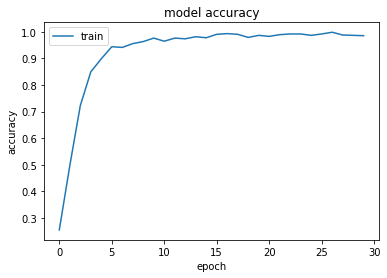

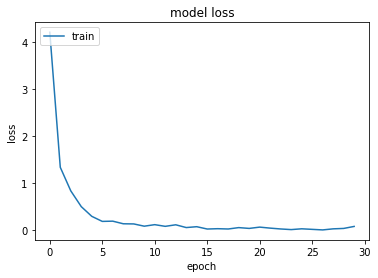

In [83]:

history, model_30_no_aum = fitModelCross(False, True, True, True, 30)
plot_history_2(history)
model_30_no_aum.save('models/cross_val_30_no_aum.h5')
    

In [ ]:
model_30_no_aum = load_model('models/cross_val_30_no_aum.h5', compile=False)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 30
Epoch 1/30
77/77 [==============================] - 76s 968ms/step - loss: 7.7852 - accuracy: 0.2260
Epoch 2/30
77/77 [==============================] - 75s 969ms/step - loss: 7.2411 - accuracy: 0.2364
Epoch 3/30
77/77 [==============================] - 75s 975ms/step - loss: 6.4344 - accuracy: 0.2623
Epoch 4/30
77/77 [==============================] - 75s 966ms/step - loss: 8.1218 - accuracy: 0.1740
Epoch 5/30
77/77 [==============================] - 75s 970ms/step - loss: 6.7360 - accuracy: 0.2818
Epoch 6/30
77/77 [==============================] - 75s 968ms/step - loss: 8.0421 - accuracy: 0.2286
Epoch 7/30
77/77 [==============================] - 74s 962ms/step - loss: 7.5373 - accuracy: 0.2558
Epoch 8/30
77/77 [==============================] - 75s 968ms/step - loss: 7.5208 - accuracy: 0.2636
Epoch 9/30
77/77 [==============================] - 75s 965ms/step - loss: 7.6337 - accuracy: 0.2779
E

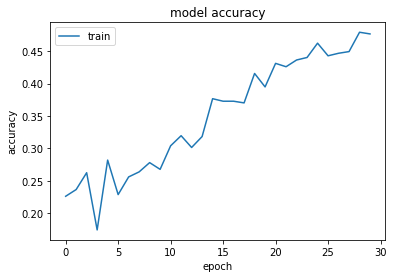

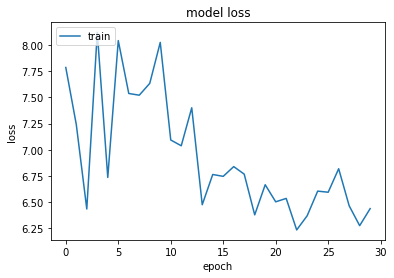

In [84]:

history, model_30_aum = fitModelCross(True, True, True, True, 30)
plot_history_2(history)
model_30_aum.save('models/cross_val_30_aum.h5')    
  

In [ ]:
model_30_aum = load_model('models/cross_val_30_aum.h5', compile=False)

## Experimentos

### Datos de test

Para esta validación cruzada se utilizan datos de otra base de datos (FID300), aunque no se dispone de información de marca, se han preseleccionado algunas imágenes que visualmente se puede intuir su marca.

In [85]:
#cargar imágenes del otro conjunto de datos

fid300ref = get_images("fid300/references")
fid300crop = get_images("fid300/tracks_cropped")

print(fid300ref[0])


Nº files: 1175
Nº files: 300
00481.png


In [86]:
#Función para la predicción

from tensorflow.keras.preprocessing.image import  load_img, img_to_array
import cv2


def predict_image(image_dir, model, doGray, doBin, doCrop):
    #print(image_dir)
    raw_img = cv2.imread(image_dir)
    img = cv2.imread(image_dir)

    #img = io.imread(image_dir)
    #h,w = img.shape #guardar el shape por si se hace crop poder hacer el resize 
    if doGray:#escala de grises
        #img = rgb2gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if doBin: #blanco y negro
        test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
    if doCrop: #quitar columnas/filas blancas
        img = crop_image(img)
    img = cv2.resize(img, (832,280), interpolation = cv2.INTER_AREA)
    img = img_as_float(img) 
    img=img /255.0
    img = np.expand_dims(img, axis=0)
    #print(img.shape)
    #raw_image = load_img(image_dir, target_size=(832,280), color_mode = "grayscale")
    #image = img_to_array(raw_image)
    #image = np.expand_dims(image, axis=0)
    #image = image / 255.0
    pred = model.predict(img)
  
    return raw_img, pred

### Experimentos con imágenes de referencia (completas)

### Experimentos con imágenes reales recortadas (parciales o difuminadas)

Al utilizar imágenes de otro conjunto de datos, que además estan tomadas con otras técnicas, se observa (mediante análisi qualitativo visual) que no parece acertar la marca. Seguramente esto se debe porque el modelo es demasiado especializado en el tipo de datos.

A continuación 

In [87]:
 

def testImage(file, model,folder ="fid300/references/"):
    img, pred = predict_image(folder+file, model, True, True, False)
    sort_index = np.argsort(-pred)
    result = pd.DataFrame({"brand":show_brands['y'], "pred":pred[0]})
    display(result)
    print(result.to_numpy())
    #print(-pred)
    brand= show_brands[show_brands['factor_brand'] == sort_index[0][0]]['y'].iloc[0]
    plt.figure()
    plt.title('img:'+file+" predicted:"+brand)
    plt.imshow(img)
    plt.show()
    return brand

   

In [88]:
def showBrandExample(brand):
    
    filtered = df_shoe_brand[df_shoe_brand['y']==brand]  #persona+contador de calzado
   
    print(brand)
    fig = plt.figure(figsize=(10, 7))
    fig.tight_layout(pad=50.0)
    for i in range(3):
        index = random.randint(0, len(filtered)-1)
        image = load_img('./images/{}'.format(filtered['X'].iloc[index]))
      # Show image
        fig.add_subplot(1, 3, i+1)
        plt.imshow(image)
        plt.title(filtered['X'].iloc[index])
    plt.show()
        

# Analisis de resultados


Para analizar los resultados se han seleccionado 5 imágenes diferentes y con suelas facilmente identificables por marca disponible en el conjunto de datos de entrenamiento o no.

La selección se ha realizado de manera visual, priorizando aquellas facilmente reconocibles y añadiendo alguna de marcas desconocidas.

00011 Nike  
00109 Adidas  
00252 Converse  
00033 Puma (None)  
00082 Lacoste (None) 



Nike


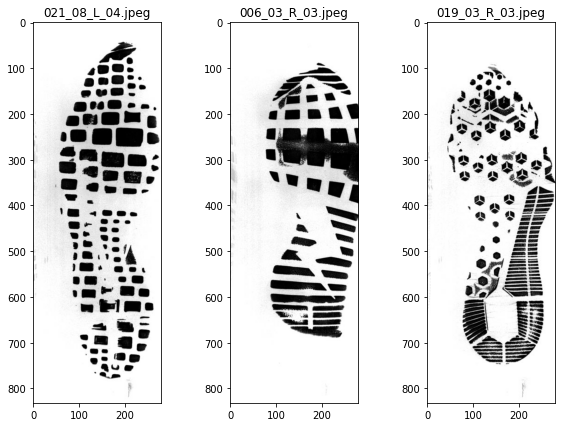

In [61]:
#Muestra 3 imágenes de Nike, Adidas y Converse.
showBrandExample("Nike")

Adidas


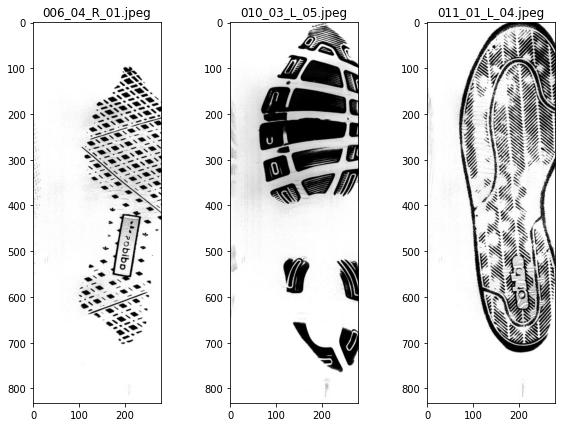

In [56]:
showBrandExample("Adidas")

Converse


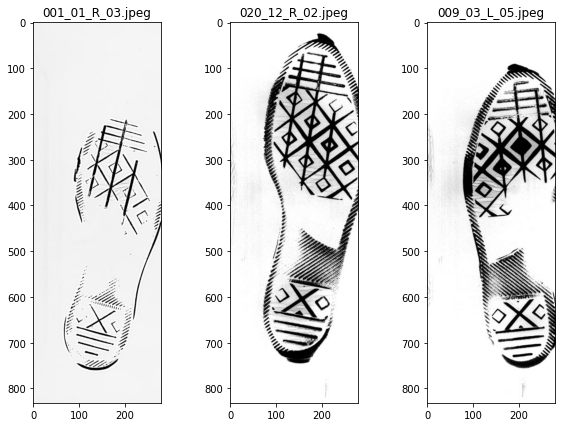

In [66]:
showBrandExample("Converse")



## Experimentos con imágenes de referencia

### 00011.png (Nike)

1/1 [==============================] - 0s 57ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,5.118688e-19
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 5.118688239260696e-19]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


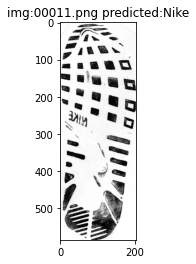

'Nike'

In [96]:
# epoch=10 sin aumentación
testImage("00011.png", model_10_no_aum)



1/1 [==============================] - 0s 56ms/step


,brand,pred
3,Asics,4.582438e-13
8,Skechers,1.836710e-06
15,Sperry,4.083016e-11
17,Adidas,1.376953e-09
18,Nike,9.999982e-01
31,Converse,1.466115e-23
57,Saucony,1.349209e-34


[['Asics' 4.582438486826212e-13]
 ['Skechers' 1.8367098846283625e-06]
 ['Sperry' 4.083015522904354e-11]
 ['Adidas' 1.3769531070906282e-09]
 ['Nike' 0.9999982118606567]
 ['Converse' 1.466114716204441e-23]
 ['Saucony' 1.3492091126166715e-34]]


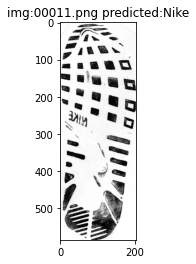

'Nike'

In [97]:
## epoch=10 con aumentación
testImage("00011.png", model_10_aum)


1/1 [==============================] - 0s 53ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,1.664375e-29
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 1.664374664854697e-29]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


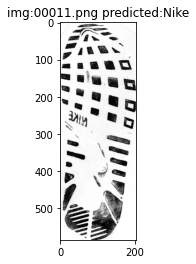

'Nike'

In [98]:
# epoch=30 sin aumentación
testImage("00011.png", model_30_no_aum)



1/1 [==============================] - 0s 56ms/step


,brand,pred
3,Asics,4.607729e-13
8,Skechers,1.462328e-02
15,Sperry,1.132234e-07
17,Adidas,9.737242e-05
18,Nike,9.852792e-01
31,Converse,3.108489e-09
57,Saucony,1.607178e-25


[['Asics' 4.607729128802696e-13]
 ['Skechers' 0.014623284339904785]
 ['Sperry' 1.1322342174935329e-07]
 ['Adidas' 9.737241634866223e-05]
 ['Nike' 0.9852792024612427]
 ['Converse' 3.108489021741434e-09]
 ['Saucony' 1.6071777533834598e-25]]


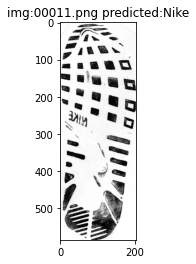

'Nike'

In [99]:
# epoch=30 con aumentación
testImage("00011.png", model_30_aum)

### 00109.png (Adidas)


1/1 [==============================] - 0s 47ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,5.090725e-19
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 5.090725398653341e-19]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


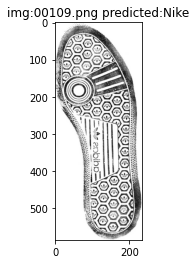

'Nike'

In [100]:
# epoch=10 sin aumentación
testImage("00109.png", model_10_no_aum)



1/1 [==============================] - 0s 51ms/step


,brand,pred
3,Asics,4.541421e-13
8,Skechers,1.817872e-06
15,Sperry,4.046862e-11
17,Adidas,1.369018e-09
18,Nike,9.999982e-01
31,Converse,1.442752e-23
57,Saucony,1.326712e-34


[['Asics' 4.541421492337827e-13]
 ['Skechers' 1.8178720893047284e-06]
 ['Sperry' 4.0468624978862167e-11]
 ['Adidas' 1.3690182321113298e-09]
 ['Nike' 0.9999982118606567]
 ['Converse' 1.4427518116354156e-23]
 ['Saucony' 1.3267115971509974e-34]]


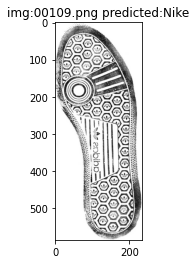

'Nike'

In [101]:
# epoch=10 con aumentación
testImage("00109.png", model_10_aum)



1/1 [==============================] - 0s 61ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,1.636197e-29
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 1.6361974069886503e-29]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


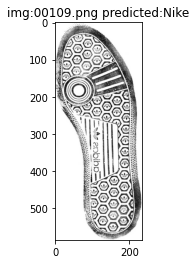

'Nike'

In [106]:
# epoch=30 sin aumentación
testImage("00109.png", model_30_no_aum)

1/1 [==============================] - 0s 55ms/step


,brand,pred
3,Asics,4.607625e-13
8,Skechers,1.467953e-02
15,Sperry,1.146998e-07
17,Adidas,9.733697e-05
18,Nike,9.852231e-01
31,Converse,3.108413e-09
57,Saucony,1.609976e-25


[['Asics' 4.607625045394137e-13]
 ['Skechers' 0.014679527841508389]
 ['Sperry' 1.1469976612943356e-07]
 ['Adidas' 9.733696788316593e-05]
 ['Nike' 0.9852230548858643]
 ['Converse' 3.10841263839734e-09]
 ['Saucony' 1.6099762374447313e-25]]


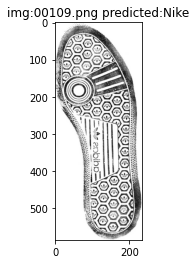

'Nike'

In [105]:
# epoch=30 con aumentación
testImage("00109.png", model_30_aum)

### 00252.png (Converse)

1/1 [==============================] - 0s 44ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,5.111020e-19
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 5.111020274982329e-19]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


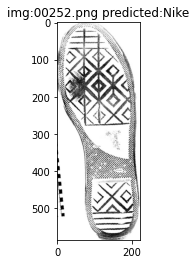

'Nike'

In [107]:
# epoch=10 sin aumentación
testImage("00252.png", model_10_no_aum)


1/1 [==============================] - 0s 47ms/step


,brand,pred
3,Asics,4.545824e-13
8,Skechers,1.824667e-06
15,Sperry,4.231113e-11
17,Adidas,1.367891e-09
18,Nike,9.999982e-01
31,Converse,1.460042e-23
57,Saucony,1.347152e-34


[['Asics' 4.5458238952592045e-13]
 ['Skechers' 1.8246668105348363e-06]
 ['Sperry' 4.2311130293848365e-11]
 ['Adidas' 1.3678906896075205e-09]
 ['Nike' 0.9999982118606567]
 ['Converse' 1.460042380500412e-23]
 ['Saucony' 1.3471519975027325e-34]]


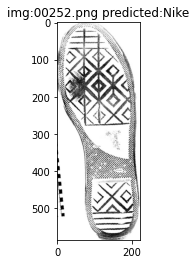

'Nike'

In [108]:
# epoch=10 con aumentación
testImage("00252.png", model_10_aum)

1/1 [==============================] - 0s 48ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,1.669296e-29
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 1.669296168178991e-29]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


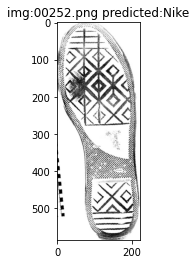

'Nike'

In [109]:
# epoch=30 sin aumentación
testImage("00252.png", model_30_no_aum)

1/1 [==============================] - 0s 48ms/step


,brand,pred
3,Asics,4.577493e-13
8,Skechers,1.469818e-02
15,Sperry,1.143537e-07
17,Adidas,9.709243e-05
18,Nike,9.852046e-01
31,Converse,3.096644e-09
57,Saucony,1.590322e-25


[['Asics' 4.57749289861642e-13]
 ['Skechers' 0.014698177576065063]
 ['Sperry' 1.1435368207912688e-07]
 ['Adidas' 9.709243022371083e-05]
 ['Nike' 0.9852045774459839]
 ['Converse' 3.0966436082024984e-09]
 ['Saucony' 1.5903218912506662e-25]]


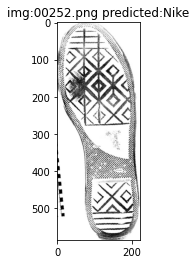

'Nike'

In [110]:
# epoch=30 con aumentación
testImage("00252.png", model_30_aum)

### 00082.png (Lacoste - None)

1/1 [==============================] - 0s 53ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,5.197115e-19
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 5.197114784100497e-19]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


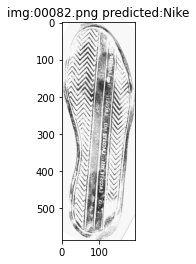

'Nike'

In [111]:
# epoch=10 sin aumentación
testImage("00082.png", model_10_no_aum)

1/1 [==============================] - 0s 50ms/step


,brand,pred
3,Asics,4.609860e-13
8,Skechers,1.832843e-06
15,Sperry,4.096026e-11
17,Adidas,1.385024e-09
18,Nike,9.999982e-01
31,Converse,1.478335e-23
57,Saucony,1.372360e-34


[['Asics' 4.60985958607163e-13]
 ['Skechers' 1.8328428268432617e-06]
 ['Sperry' 4.0960262959188753e-11]
 ['Adidas' 1.3850237623458383e-09]
 ['Nike' 0.9999982118606567]
 ['Converse' 1.478335276031582e-23]
 ['Saucony' 1.3723603820206203e-34]]


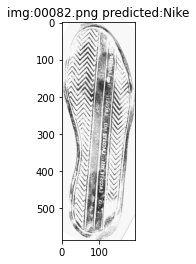

'Nike'

In [112]:
# epoch=10 con aumentación
testImage("00082.png", model_10_aum)

1/1 [==============================] - 0s 53ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,1.669054e-29
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 1.6690542232297273e-29]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


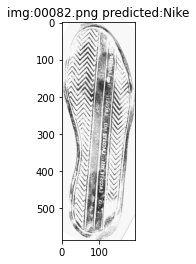

'Nike'

In [113]:
# epoch=30 sin aumentación
testImage("00082.png", model_30_no_aum)

1/1 [==============================] - 0s 52ms/step


,brand,pred
3,Asics,4.648070e-13
8,Skechers,1.467147e-02
15,Sperry,1.146006e-07
17,Adidas,9.765330e-05
18,Nike,9.852307e-01
31,Converse,3.131341e-09
57,Saucony,1.635498e-25


[['Asics' 4.648070123236536e-13]
 ['Skechers' 0.01467146910727024]
 ['Sperry' 1.1460061699608559e-07]
 ['Adidas' 9.765329741640016e-05]
 ['Nike' 0.9852307438850403]
 ['Converse' 3.1313409643018986e-09]
 ['Saucony' 1.6354984761784763e-25]]


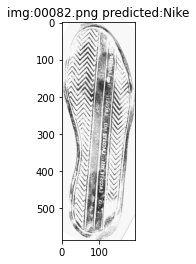

'Nike'

In [114]:
# epoch=30 con aumentación
testImage("00082.png", model_30_aum)

### 00033.png (Puma - None)

1/1 [==============================] - 0s 50ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,5.227476e-19
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 5.227476448484256e-19]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


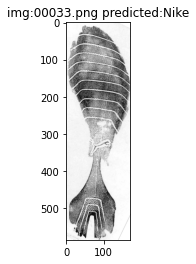

'Nike'

In [115]:
# epoch=10 sin aumentación
testImage("00033.png", model_10_no_aum)

1/1 [==============================] - 0s 49ms/step


,brand,pred
3,Asics,4.615808e-13
8,Skechers,1.824994e-06
15,Sperry,4.088221e-11
17,Adidas,1.387586e-09
18,Nike,9.999982e-01
31,Converse,1.471033e-23
57,Saucony,1.363032e-34


[['Asics' 4.615807519189885e-13]
 ['Skechers' 1.824994001253799e-06]
 ['Sperry' 4.088221081111065e-11]
 ['Adidas' 1.3875859350420683e-09]
 ['Nike' 0.9999982118606567]
 ['Converse' 1.4710334217206752e-23]
 ['Saucony' 1.3630317323208916e-34]]


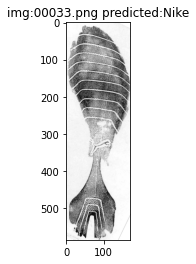

'Nike'

In [116]:
# epoch=10 con aumentación
testImage("00033.png", model_10_aum)

1/1 [==============================] - 0s 48ms/step


,brand,pred
3,Asics,0.000000e+00
8,Skechers,0.000000e+00
15,Sperry,0.000000e+00
17,Adidas,1.661647e-29
18,Nike,1.000000e+00
31,Converse,0.000000e+00
57,Saucony,0.000000e+00


[['Asics' 0.0]
 ['Skechers' 0.0]
 ['Sperry' 0.0]
 ['Adidas' 1.6616467656444048e-29]
 ['Nike' 1.0]
 ['Converse' 0.0]
 ['Saucony' 0.0]]


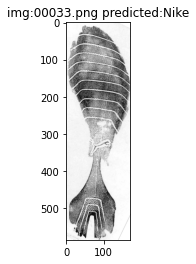

'Nike'

In [117]:
# epoch=30 sin aumentación
testImage("00033.png", model_30_no_aum)

1/1 [==============================] - 0s 49ms/step


,brand,pred
3,Asics,4.657932e-13
8,Skechers,1.467306e-02
15,Sperry,1.144220e-07
17,Adidas,9.758239e-05
18,Nike,9.852292e-01
31,Converse,3.134180e-09
57,Saucony,1.637406e-25


[['Asics' 4.657932026197464e-13]
 ['Skechers' 0.014673055149614811]
 ['Sperry' 1.1442199365774286e-07]
 ['Adidas' 9.758239320944995e-05]
 ['Nike' 0.9852291941642761]
 ['Converse' 3.13418047070968e-09]
 ['Saucony' 1.6374061637144303e-25]]


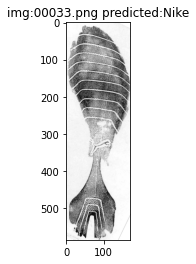

'Nike'

In [118]:
# epoch=30 con aumentación
testImage("00033.png", model_30_aum)